In [ ]:
# This is the implementation of the EncDec-AD model based on the paper "LSTM-based Encoder-Decoder for Multi-sensor Anomaly Detection". And a slight variantion "TimeNet" based on the paper "TimeNet: Pre-trained deep recurrent neural network for time series classiﬁcation", which has been shown that achives better performance in the time series anomaly detection scenario. The only difference is the second model feeds constants to its decoder as input.

In [13]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from functools import reduce

# Definition of the EncDec-AD model

In [14]:
# decoder input: original time series value at last time step

class EncDecAD(object):

    def __init__(self, hidden_num, inputs, cell=None, optimizer=None, reverse=True, decode_without_input=False,):

        self.batch_num = inputs[0].get_shape().as_list()[0]
        self.elem_num = inputs[0].get_shape().as_list()[1]
        if cell is None:
            self._enc_cell = LSTMCell(hidden_num)
            self._dec_cell = LSTMCell(hidden_num)

        else:
            self._enc_cell = cell
            self._dec_cell = cell

        with tf.variable_scope('encoder'):
            (self.z_codes, self.enc_state) = tf.contrib.rnn.static_rnn(self._enc_cell, inputs, dtype=tf.float32)

        with tf.variable_scope('decoder') as vs:
            dec_weight_ = tf.Variable(tf.truncated_normal([hidden_num,
                    self.elem_num], dtype=tf.float32), name='dec_weight')

            dec_bias_ = tf.Variable(tf.constant(0.1,shape=[self.elem_num],dtype=tf.float32), name='dec_bias')

            if decode_without_input:
                dec_inputs = [tf.zeros(tf.shape(inputs[0]),dtype=tf.float32) for _ in range(len(inputs))]
                (dec_outputs, dec_state) = tf.contrib.rnn.static_rnn(self._dec_cell, dec_inputs, initial_state=self.enc_state, dtype=tf.float32)

                if reverse:
                    dec_outputs = dec_outputs[::-1]
                    
                dec_output_ = tf.transpose(tf.stack(dec_outputs), [1, 0,2])
                dec_weight_ = tf.tile(tf.expand_dims(dec_weight_, 0),[self.batch_num, 1, 1])
                self.output_ = tf.matmul(dec_output_, dec_weight_) + dec_bias_

            else:
                dec_state = self.enc_state
                dec_input_ = tf.zeros(tf.shape(inputs[0]),dtype=tf.float32)
                dec_outputs = []
                
                for step in range(len(inputs)):
                    if step > 0:
                        vs.reuse_variables()
                    (dec_input_, dec_state) =self._dec_cell(dec_input_, dec_state)
                    dec_input_ = tf.matmul(dec_input_, dec_weight_) + dec_bias_
                    dec_outputs.append(dec_input_)

                if reverse:
                    dec_outputs = dec_outputs[::-1]

                self.output_ = tf.transpose(tf.stack(dec_outputs), [1, 0, 2])
        self.input_ = tf.transpose(tf.stack(inputs), [1, 0, 2])
        self.loss = tf.reduce_mean(tf.square(self.input_ - self.output_))

        if optimizer is None:
            self.train = tf.train.AdamOptimizer().minimize(self.loss)

        else:
            self.train = optimizer.minimize(self.loss)
        

# Load Power Demand Dataset

In [15]:
# The dataset is divided into 6 parts, namely training_normal, validation_1,
#validation_2, test_normal, validation_anomaly, test_anomaly.

root = "C:/Users/Bin/Documents/Datasets/EncDec-AD dataset/preprocessed/PowerDemand/6_subsets/"

sn = pd.read_csv(root + "training_normal.csv",header=None)
vn1 = pd.read_csv(root + "validation_1.csv",header=None)
vn2 = pd.read_csv(root + "validation_2.csv",header=None)
tn = pd.read_csv(root + "test_normal.csv",header=None)

va = pd.read_csv(root + "validation_anomaly.csv",header=None)
ta = pd.read_csv(root + "test_anomaly.csv",header=None)    


# Initialization

In [16]:
tf.reset_default_graph()

batch_num = 3

hidden_num = 40

step_num = 84

elem_num = 1

iteration = 10000

In [17]:
t1 = sn.shape[0]//step_num
t2 = va.shape[0]//step_num
t3 = vn1.shape[0]//step_num
t4 = vn2.shape[0]//step_num
t5 = tn.shape[0]//step_num
t6 = ta.shape[0]//step_num

sn_list = [sn[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t1)]
va_list = [va[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t2)]
vn1_list = [vn1[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t3)]
vn2_list = [vn2[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t4)]

tn_list = [tn[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t5)]
ta_list = [ta[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t6)]


In [18]:
# input placeholder
p_input = tf.placeholder(tf.float32, shape=(batch_num, step_num, elem_num))
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)]

# define cell
cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)

In [19]:
ae = EncDecAD(hidden_num, p_inputs,cell=cell,
                     decode_without_input=True)

# Training

In [20]:
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(iteration):
        data =[]
        for temp in range(batch_num):
            ind = np.random.randint(0,len(sn_list)-1)
            sub = sn_list[ind]
            data.append(sub)
        data = np.array(data)
        (loss_val, _) = sess.run([ae.loss, ae.train], {p_input: data})
        print('iter %d:' % (i + 1), loss_val)

    save_path = saver.save(sess, "C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_v3.ckpt")
    print("Model saved in file: %s" % save_path) 

iter 1: 0.0873487
iter 2: 0.0774856
iter 3: 0.0747972
iter 4: 0.0473006
iter 5: 0.0563544
iter 6: 0.0529778
iter 7: 0.0467892
iter 8: 0.0461747
iter 9: 0.0476808
iter 10: 0.0469854
iter 11: 0.0417163
iter 12: 0.0397928
iter 13: 0.0471486
iter 14: 0.0448271
iter 15: 0.0517025
iter 16: 0.0441572
iter 17: 0.0412691
iter 18: 0.0377366
iter 19: 0.0421779
iter 20: 0.0434049
iter 21: 0.037894
iter 22: 0.0372395
iter 23: 0.0354184
iter 24: 0.0441149
iter 25: 0.0377547
iter 26: 0.041198
iter 27: 0.0426289
iter 28: 0.036131
iter 29: 0.037993
iter 30: 0.0330795
iter 31: 0.0370954
iter 32: 0.040085
iter 33: 0.0425234
iter 34: 0.0434455
iter 35: 0.0390342
iter 36: 0.0353902
iter 37: 0.0435254
iter 38: 0.0371757
iter 39: 0.0350046
iter 40: 0.0367982
iter 41: 0.0343208
iter 42: 0.0355451
iter 43: 0.035687
iter 44: 0.0336423
iter 45: 0.0364809
iter 46: 0.0282414
iter 47: 0.0475971
iter 48: 0.0376932
iter 49: 0.0467857
iter 50: 0.0363974
iter 51: 0.0358724
iter 52: 0.0370302
iter 53: 0.0373705
iter 54:

iter 422: 0.0332253
iter 423: 0.0375107
iter 424: 0.0354658
iter 425: 0.0324193
iter 426: 0.0361274
iter 427: 0.0309746
iter 428: 0.0350085
iter 429: 0.0329935
iter 430: 0.0331267
iter 431: 0.0430444
iter 432: 0.034199
iter 433: 0.0343929
iter 434: 0.0352586
iter 435: 0.0327747
iter 436: 0.0367446
iter 437: 0.0369358
iter 438: 0.0341655
iter 439: 0.0373733
iter 440: 0.0359276
iter 441: 0.0383419
iter 442: 0.0336212
iter 443: 0.0358976
iter 444: 0.0363545
iter 445: 0.0285584
iter 446: 0.0353316
iter 447: 0.0374324
iter 448: 0.0370784
iter 449: 0.0302094
iter 450: 0.0399758
iter 451: 0.033469
iter 452: 0.033234
iter 453: 0.0364699
iter 454: 0.0311655
iter 455: 0.0346996
iter 456: 0.0327621
iter 457: 0.0333716
iter 458: 0.02884
iter 459: 0.0349898
iter 460: 0.0329483
iter 461: 0.0361054
iter 462: 0.0383646
iter 463: 0.0349737
iter 464: 0.0292664
iter 465: 0.0330947
iter 466: 0.041848
iter 467: 0.0318451
iter 468: 0.0372187
iter 469: 0.0360322
iter 470: 0.0320757
iter 471: 0.0307698
iter 4

iter 834: 0.0284393
iter 835: 0.0348991
iter 836: 0.033975
iter 837: 0.0307711
iter 838: 0.0280888
iter 839: 0.0279188
iter 840: 0.0308486
iter 841: 0.0357865
iter 842: 0.0324436
iter 843: 0.0315276
iter 844: 0.0392961
iter 845: 0.029861
iter 846: 0.0327265
iter 847: 0.0294089
iter 848: 0.0403906
iter 849: 0.0303944
iter 850: 0.0336513
iter 851: 0.0338044
iter 852: 0.0307794
iter 853: 0.0297211
iter 854: 0.0305811
iter 855: 0.0310817
iter 856: 0.0313172
iter 857: 0.0254121
iter 858: 0.030414
iter 859: 0.0328997
iter 860: 0.0316773
iter 861: 0.0346512
iter 862: 0.0296214
iter 863: 0.0261143
iter 864: 0.0355235
iter 865: 0.0312001
iter 866: 0.0303369
iter 867: 0.029764
iter 868: 0.0281281
iter 869: 0.0324818
iter 870: 0.0334808
iter 871: 0.0293309
iter 872: 0.0355437
iter 873: 0.0342824
iter 874: 0.031018
iter 875: 0.0338388
iter 876: 0.0247015
iter 877: 0.0317397
iter 878: 0.0337366
iter 879: 0.0320657
iter 880: 0.0279522
iter 881: 0.0346516
iter 882: 0.0325426
iter 883: 0.0318003
iter 

iter 1236: 0.0312913
iter 1237: 0.0359426
iter 1238: 0.0302169
iter 1239: 0.0325906
iter 1240: 0.0288908
iter 1241: 0.0324707
iter 1242: 0.0271355
iter 1243: 0.0285809
iter 1244: 0.0299173
iter 1245: 0.0282814
iter 1246: 0.0301887
iter 1247: 0.02935
iter 1248: 0.0348017
iter 1249: 0.0316507
iter 1250: 0.0368848
iter 1251: 0.0325104
iter 1252: 0.0317995
iter 1253: 0.0292378
iter 1254: 0.0339432
iter 1255: 0.0303551
iter 1256: 0.0262924
iter 1257: 0.0279897
iter 1258: 0.0374624
iter 1259: 0.0406383
iter 1260: 0.0256563
iter 1261: 0.0280969
iter 1262: 0.0296998
iter 1263: 0.0312387
iter 1264: 0.0265663
iter 1265: 0.0323956
iter 1266: 0.0296699
iter 1267: 0.0324952
iter 1268: 0.0285731
iter 1269: 0.0339419
iter 1270: 0.0295039
iter 1271: 0.027775
iter 1272: 0.0331962
iter 1273: 0.0293555
iter 1274: 0.0260495
iter 1275: 0.0318101
iter 1276: 0.0345234
iter 1277: 0.0264615
iter 1278: 0.0277468
iter 1279: 0.0274547
iter 1280: 0.0259124
iter 1281: 0.0286509
iter 1282: 0.0295368
iter 1283: 0.027

iter 1622: 0.00659415
iter 1623: 0.00619522
iter 1624: 0.00548009
iter 1625: 0.00876326
iter 1626: 0.00659951
iter 1627: 0.00593777
iter 1628: 0.00578177
iter 1629: 0.00588613
iter 1630: 0.00564789
iter 1631: 0.0131581
iter 1632: 0.00558736
iter 1633: 0.00749907
iter 1634: 0.0057984
iter 1635: 0.00688305
iter 1636: 0.00534004
iter 1637: 0.0107437
iter 1638: 0.00719105
iter 1639: 0.00784892
iter 1640: 0.00749889
iter 1641: 0.00629155
iter 1642: 0.0103247
iter 1643: 0.00737475
iter 1644: 0.00635931
iter 1645: 0.00632496
iter 1646: 0.00951917
iter 1647: 0.00702334
iter 1648: 0.0087596
iter 1649: 0.00747542
iter 1650: 0.00809693
iter 1651: 0.00636723
iter 1652: 0.00875756
iter 1653: 0.00682874
iter 1654: 0.00746162
iter 1655: 0.00779628
iter 1656: 0.00737765
iter 1657: 0.0076985
iter 1658: 0.00788968
iter 1659: 0.00802938
iter 1660: 0.00660021
iter 1661: 0.00655366
iter 1662: 0.00652412
iter 1663: 0.00746376
iter 1664: 0.00712058
iter 1665: 0.00777917
iter 1666: 0.00707035
iter 1667: 0.006

iter 1998: 0.00803227
iter 1999: 0.00539125
iter 2000: 0.00564431
iter 2001: 0.00606173
iter 2002: 0.00641353
iter 2003: 0.00607917
iter 2004: 0.0066883
iter 2005: 0.00595113
iter 2006: 0.00585741
iter 2007: 0.00610223
iter 2008: 0.00604021
iter 2009: 0.00563992
iter 2010: 0.00442077
iter 2011: 0.00890983
iter 2012: 0.00974772
iter 2013: 0.00422071
iter 2014: 0.00907348
iter 2015: 0.00749869
iter 2016: 0.0062305
iter 2017: 0.00752739
iter 2018: 0.00740868
iter 2019: 0.00818128
iter 2020: 0.00586476
iter 2021: 0.00763593
iter 2022: 0.0112907
iter 2023: 0.00776616
iter 2024: 0.0064785
iter 2025: 0.00956796
iter 2026: 0.00819717
iter 2027: 0.00775582
iter 2028: 0.00540502
iter 2029: 0.00740251
iter 2030: 0.0091728
iter 2031: 0.00534318
iter 2032: 0.00538847
iter 2033: 0.00589126
iter 2034: 0.00680865
iter 2035: 0.00751077
iter 2036: 0.00517365
iter 2037: 0.00633296
iter 2038: 0.0104649
iter 2039: 0.00610203
iter 2040: 0.00416306
iter 2041: 0.00701705
iter 2042: 0.0105342
iter 2043: 0.0050

iter 2375: 0.0071245
iter 2376: 0.00604728
iter 2377: 0.00558608
iter 2378: 0.00652513
iter 2379: 0.00590603
iter 2380: 0.00537255
iter 2381: 0.00686991
iter 2382: 0.00415797
iter 2383: 0.00568394
iter 2384: 0.00419035
iter 2385: 0.00469301
iter 2386: 0.00418199
iter 2387: 0.00583243
iter 2388: 0.00478515
iter 2389: 0.00571191
iter 2390: 0.00398779
iter 2391: 0.00670506
iter 2392: 0.0043593
iter 2393: 0.00614805
iter 2394: 0.00562337
iter 2395: 0.00557513
iter 2396: 0.00596724
iter 2397: 0.00729512
iter 2398: 0.00605346
iter 2399: 0.00585641
iter 2400: 0.00674292
iter 2401: 0.00655172
iter 2402: 0.00494121
iter 2403: 0.00545808
iter 2404: 0.00763314
iter 2405: 0.0070692
iter 2406: 0.00545301
iter 2407: 0.00800514
iter 2408: 0.00476677
iter 2409: 0.00397253
iter 2410: 0.00400914
iter 2411: 0.00459998
iter 2412: 0.00528577
iter 2413: 0.00440115
iter 2414: 0.00492041
iter 2415: 0.00397038
iter 2416: 0.00546835
iter 2417: 0.00385539
iter 2418: 0.00430205
iter 2419: 0.00442641
iter 2420: 0.

iter 2751: 0.00394206
iter 2752: 0.00501549
iter 2753: 0.00577603
iter 2754: 0.00473429
iter 2755: 0.00391669
iter 2756: 0.0030533
iter 2757: 0.00446657
iter 2758: 0.00480102
iter 2759: 0.0049711
iter 2760: 0.00398313
iter 2761: 0.00343682
iter 2762: 0.00458172
iter 2763: 0.0042298
iter 2764: 0.00373845
iter 2765: 0.00366182
iter 2766: 0.00338382
iter 2767: 0.00460033
iter 2768: 0.00489717
iter 2769: 0.00380105
iter 2770: 0.00564623
iter 2771: 0.00363364
iter 2772: 0.0050833
iter 2773: 0.00529599
iter 2774: 0.004879
iter 2775: 0.00428069
iter 2776: 0.00411803
iter 2777: 0.00339859
iter 2778: 0.00432839
iter 2779: 0.00579757
iter 2780: 0.00418371
iter 2781: 0.00599852
iter 2782: 0.00462668
iter 2783: 0.00354189
iter 2784: 0.00555055
iter 2785: 0.00495905
iter 2786: 0.00485793
iter 2787: 0.00384315
iter 2788: 0.00271782
iter 2789: 0.00470968
iter 2790: 0.00422998
iter 2791: 0.00466417
iter 2792: 0.00378218
iter 2793: 0.00421939
iter 2794: 0.0036427
iter 2795: 0.00471118
iter 2796: 0.0051

iter 3129: 0.00448055
iter 3130: 0.00312932
iter 3131: 0.00361799
iter 3132: 0.00329427
iter 3133: 0.00326402
iter 3134: 0.00626546
iter 3135: 0.00350448
iter 3136: 0.00429549
iter 3137: 0.00483778
iter 3138: 0.0029165
iter 3139: 0.00438273
iter 3140: 0.00447478
iter 3141: 0.00462918
iter 3142: 0.00363683
iter 3143: 0.00446626
iter 3144: 0.00337613
iter 3145: 0.00437486
iter 3146: 0.00362912
iter 3147: 0.00361531
iter 3148: 0.0033369
iter 3149: 0.0047592
iter 3150: 0.00429425
iter 3151: 0.00504727
iter 3152: 0.00412037
iter 3153: 0.00500555
iter 3154: 0.00423564
iter 3155: 0.00325613
iter 3156: 0.00409857
iter 3157: 0.00468646
iter 3158: 0.00333761
iter 3159: 0.00343891
iter 3160: 0.00410012
iter 3161: 0.00389993
iter 3162: 0.00385367
iter 3163: 0.00332621
iter 3164: 0.00363523
iter 3165: 0.00306008
iter 3166: 0.00419929
iter 3167: 0.00333721
iter 3168: 0.00382602
iter 3169: 0.00443897
iter 3170: 0.00356451
iter 3171: 0.0048957
iter 3172: 0.00339056
iter 3173: 0.00406533
iter 3174: 0.0

iter 3504: 0.00404856
iter 3505: 0.00393939
iter 3506: 0.00326737
iter 3507: 0.0029507
iter 3508: 0.00306395
iter 3509: 0.0038706
iter 3510: 0.00586621
iter 3511: 0.00435279
iter 3512: 0.00557575
iter 3513: 0.0048372
iter 3514: 0.00368586
iter 3515: 0.00383937
iter 3516: 0.00419043
iter 3517: 0.00479345
iter 3518: 0.00446276
iter 3519: 0.00538746
iter 3520: 0.00381199
iter 3521: 0.00335306
iter 3522: 0.00463508
iter 3523: 0.00370534
iter 3524: 0.00305162
iter 3525: 0.00464263
iter 3526: 0.00345848
iter 3527: 0.00335166
iter 3528: 0.00303635
iter 3529: 0.00380981
iter 3530: 0.00421359
iter 3531: 0.00483372
iter 3532: 0.00356379
iter 3533: 0.00572999
iter 3534: 0.00315176
iter 3535: 0.00451437
iter 3536: 0.00605053
iter 3537: 0.00351691
iter 3538: 0.00409275
iter 3539: 0.0039968
iter 3540: 0.00386577
iter 3541: 0.00284879
iter 3542: 0.00362539
iter 3543: 0.0041616
iter 3544: 0.00431896
iter 3545: 0.00362371
iter 3546: 0.00419011
iter 3547: 0.00332304
iter 3548: 0.0052424
iter 3549: 0.004

iter 3882: 0.00543841
iter 3883: 0.00424597
iter 3884: 0.00469796
iter 3885: 0.00422017
iter 3886: 0.00470115
iter 3887: 0.00722634
iter 3888: 0.00371658
iter 3889: 0.00439864
iter 3890: 0.00503032
iter 3891: 0.00555065
iter 3892: 0.00386642
iter 3893: 0.00445934
iter 3894: 0.00388725
iter 3895: 0.00375395
iter 3896: 0.00824753
iter 3897: 0.00487691
iter 3898: 0.00328994
iter 3899: 0.00555923
iter 3900: 0.00958734
iter 3901: 0.00405182
iter 3902: 0.00517983
iter 3903: 0.00572807
iter 3904: 0.00486126
iter 3905: 0.00409779
iter 3906: 0.00363129
iter 3907: 0.00629148
iter 3908: 0.00414321
iter 3909: 0.00362219
iter 3910: 0.00750541
iter 3911: 0.00506963
iter 3912: 0.00350621
iter 3913: 0.00350818
iter 3914: 0.00594054
iter 3915: 0.00390229
iter 3916: 0.00393575
iter 3917: 0.0066397
iter 3918: 0.0040585
iter 3919: 0.00292397
iter 3920: 0.00479223
iter 3921: 0.00398444
iter 3922: 0.00437178
iter 3923: 0.00497439
iter 3924: 0.00454363
iter 3925: 0.0037318
iter 3926: 0.00348202
iter 3927: 0.

iter 4259: 0.00432363
iter 4260: 0.00620794
iter 4261: 0.00428936
iter 4262: 0.0042292
iter 4263: 0.00486772
iter 4264: 0.00559858
iter 4265: 0.00398615
iter 4266: 0.00467786
iter 4267: 0.00489993
iter 4268: 0.00346614
iter 4269: 0.00296139
iter 4270: 0.00427893
iter 4271: 0.00401067
iter 4272: 0.00338067
iter 4273: 0.00433519
iter 4274: 0.00466491
iter 4275: 0.00395469
iter 4276: 0.00313239
iter 4277: 0.00351986
iter 4278: 0.00306091
iter 4279: 0.00363233
iter 4280: 0.00341573
iter 4281: 0.0045849
iter 4282: 0.00347182
iter 4283: 0.00525529
iter 4284: 0.00548278
iter 4285: 0.00291664
iter 4286: 0.00463967
iter 4287: 0.0045973
iter 4288: 0.00676626
iter 4289: 0.00418409
iter 4290: 0.00374278
iter 4291: 0.00642227
iter 4292: 0.00274545
iter 4293: 0.003745
iter 4294: 0.00483596
iter 4295: 0.00425066
iter 4296: 0.00308279
iter 4297: 0.00418041
iter 4298: 0.00494513
iter 4299: 0.00329387
iter 4300: 0.00426219
iter 4301: 0.00568111
iter 4302: 0.00377976
iter 4303: 0.00450026
iter 4304: 0.00

iter 4635: 0.00308697
iter 4636: 0.00447996
iter 4637: 0.00321006
iter 4638: 0.0042108
iter 4639: 0.00312309
iter 4640: 0.00281918
iter 4641: 0.00523155
iter 4642: 0.00437069
iter 4643: 0.00316952
iter 4644: 0.00515027
iter 4645: 0.00297502
iter 4646: 0.00366814
iter 4647: 0.00372285
iter 4648: 0.00331569
iter 4649: 0.00283448
iter 4650: 0.0044725
iter 4651: 0.00336833
iter 4652: 0.00362044
iter 4653: 0.00370005
iter 4654: 0.00496438
iter 4655: 0.00340642
iter 4656: 0.00311426
iter 4657: 0.00465283
iter 4658: 0.0032627
iter 4659: 0.0049232
iter 4660: 0.0046032
iter 4661: 0.00330974
iter 4662: 0.00551406
iter 4663: 0.00432615
iter 4664: 0.00356686
iter 4665: 0.00423564
iter 4666: 0.00398517
iter 4667: 0.00422257
iter 4668: 0.00325391
iter 4669: 0.00435033
iter 4670: 0.00309633
iter 4671: 0.00375433
iter 4672: 0.00350829
iter 4673: 0.00325417
iter 4674: 0.00406956
iter 4675: 0.00423309
iter 4676: 0.00387917
iter 4677: 0.00245793
iter 4678: 0.00266406
iter 4679: 0.00330299
iter 4680: 0.00

iter 5013: 0.0035508
iter 5014: 0.00378634
iter 5015: 0.00269905
iter 5016: 0.00395824
iter 5017: 0.00411919
iter 5018: 0.00293278
iter 5019: 0.00325685
iter 5020: 0.00278356
iter 5021: 0.0030867
iter 5022: 0.00267264
iter 5023: 0.00389664
iter 5024: 0.00310413
iter 5025: 0.00282739
iter 5026: 0.00311454
iter 5027: 0.00310887
iter 5028: 0.00304318
iter 5029: 0.00296608
iter 5030: 0.00392989
iter 5031: 0.0031175
iter 5032: 0.00386937
iter 5033: 0.00296616
iter 5034: 0.00332075
iter 5035: 0.00233005
iter 5036: 0.00291424
iter 5037: 0.00299523
iter 5038: 0.00302569
iter 5039: 0.00310341
iter 5040: 0.00365582
iter 5041: 0.00334773
iter 5042: 0.0033934
iter 5043: 0.00447371
iter 5044: 0.0037006
iter 5045: 0.00396892
iter 5046: 0.00344613
iter 5047: 0.00345331
iter 5048: 0.00509559
iter 5049: 0.00403448
iter 5050: 0.00335259
iter 5051: 0.00423052
iter 5052: 0.00371938
iter 5053: 0.00293762
iter 5054: 0.00420141
iter 5055: 0.00428623
iter 5056: 0.00496664
iter 5057: 0.00305675
iter 5058: 0.00

iter 5389: 0.00483487
iter 5390: 0.0049387
iter 5391: 0.00420832
iter 5392: 0.00435857
iter 5393: 0.00375049
iter 5394: 0.00282003
iter 5395: 0.00326265
iter 5396: 0.00369683
iter 5397: 0.00360292
iter 5398: 0.00352724
iter 5399: 0.0032654
iter 5400: 0.00536644
iter 5401: 0.00423511
iter 5402: 0.00312344
iter 5403: 0.00673745
iter 5404: 0.00244835
iter 5405: 0.00454755
iter 5406: 0.00674225
iter 5407: 0.00394128
iter 5408: 0.00297906
iter 5409: 0.00391576
iter 5410: 0.00423073
iter 5411: 0.00341142
iter 5412: 0.00437728
iter 5413: 0.00357809
iter 5414: 0.00307077
iter 5415: 0.00359013
iter 5416: 0.00241846
iter 5417: 0.00337281
iter 5418: 0.00245788
iter 5419: 0.00376191
iter 5420: 0.00334903
iter 5421: 0.00360075
iter 5422: 0.00375686
iter 5423: 0.00417116
iter 5424: 0.00242052
iter 5425: 0.00334596
iter 5426: 0.00588059
iter 5427: 0.00326541
iter 5428: 0.00307853
iter 5429: 0.00384731
iter 5430: 0.00298951
iter 5431: 0.0023125
iter 5432: 0.00432285
iter 5433: 0.00529812
iter 5434: 0.

iter 5765: 0.00336796
iter 5766: 0.00269987
iter 5767: 0.0030531
iter 5768: 0.00534362
iter 5769: 0.00248072
iter 5770: 0.00326654
iter 5771: 0.0031279
iter 5772: 0.00278443
iter 5773: 0.00301338
iter 5774: 0.00385984
iter 5775: 0.00348182
iter 5776: 0.00335954
iter 5777: 0.00280388
iter 5778: 0.00417788
iter 5779: 0.00240445
iter 5780: 0.00340089
iter 5781: 0.00300742
iter 5782: 0.00328792
iter 5783: 0.00381171
iter 5784: 0.00271922
iter 5785: 0.0032205
iter 5786: 0.00275436
iter 5787: 0.00303867
iter 5788: 0.00268189
iter 5789: 0.0033168
iter 5790: 0.00299305
iter 5791: 0.00221322
iter 5792: 0.00286065
iter 5793: 0.00230963
iter 5794: 0.00259765
iter 5795: 0.00414899
iter 5796: 0.00309089
iter 5797: 0.00312321
iter 5798: 0.00291194
iter 5799: 0.00312099
iter 5800: 0.00400731
iter 5801: 0.00272585
iter 5802: 0.00274868
iter 5803: 0.00427173
iter 5804: 0.00257423
iter 5805: 0.00286445
iter 5806: 0.00292055
iter 5807: 0.00315499
iter 5808: 0.00310941
iter 5809: 0.00284621
iter 5810: 0.0

iter 6141: 0.00224873
iter 6142: 0.00219205
iter 6143: 0.00299162
iter 6144: 0.00307955
iter 6145: 0.00244025
iter 6146: 0.00316679
iter 6147: 0.00316107
iter 6148: 0.00370778
iter 6149: 0.00381864
iter 6150: 0.00320661
iter 6151: 0.00526464
iter 6152: 0.00265446
iter 6153: 0.00428771
iter 6154: 0.00356166
iter 6155: 0.00460794
iter 6156: 0.00299736
iter 6157: 0.0048203
iter 6158: 0.00324172
iter 6159: 0.00304659
iter 6160: 0.00256811
iter 6161: 0.00262476
iter 6162: 0.0047182
iter 6163: 0.00213452
iter 6164: 0.00377156
iter 6165: 0.00385454
iter 6166: 0.00285471
iter 6167: 0.00318183
iter 6168: 0.00348762
iter 6169: 0.00373558
iter 6170: 0.00239462
iter 6171: 0.00314535
iter 6172: 0.00459547
iter 6173: 0.00208539
iter 6174: 0.00369397
iter 6175: 0.00407432
iter 6176: 0.00249131
iter 6177: 0.00427513
iter 6178: 0.00422956
iter 6179: 0.00216655
iter 6180: 0.00268103
iter 6181: 0.0039857
iter 6182: 0.00345365
iter 6183: 0.00268763
iter 6184: 0.00284961
iter 6185: 0.00265023
iter 6186: 0.

iter 6518: 0.00240909
iter 6519: 0.00322471
iter 6520: 0.00207233
iter 6521: 0.00208362
iter 6522: 0.00259216
iter 6523: 0.00282136
iter 6524: 0.0022857
iter 6525: 0.00216847
iter 6526: 0.00288382
iter 6527: 0.00215318
iter 6528: 0.00173674
iter 6529: 0.00373018
iter 6530: 0.00208571
iter 6531: 0.00408944
iter 6532: 0.00236929
iter 6533: 0.00266332
iter 6534: 0.00367139
iter 6535: 0.00224427
iter 6536: 0.00221649
iter 6537: 0.00356376
iter 6538: 0.00263685
iter 6539: 0.00235517
iter 6540: 0.00249221
iter 6541: 0.0045614
iter 6542: 0.00252454
iter 6543: 0.00362142
iter 6544: 0.00217815
iter 6545: 0.00178023
iter 6546: 0.00349164
iter 6547: 0.00352693
iter 6548: 0.00190747
iter 6549: 0.00395018
iter 6550: 0.00267641
iter 6551: 0.00274203
iter 6552: 0.00266508
iter 6553: 0.00294684
iter 6554: 0.00313697
iter 6555: 0.00289315
iter 6556: 0.00204243
iter 6557: 0.00216181
iter 6558: 0.00176387
iter 6559: 0.00290084
iter 6560: 0.00211266
iter 6561: 0.00247542
iter 6562: 0.00315885
iter 6563: 0

iter 6894: 0.00236212
iter 6895: 0.00333377
iter 6896: 0.00343286
iter 6897: 0.00207322
iter 6898: 0.00231214
iter 6899: 0.00437926
iter 6900: 0.00260179
iter 6901: 0.00243191
iter 6902: 0.00340196
iter 6903: 0.00215215
iter 6904: 0.00249078
iter 6905: 0.00383981
iter 6906: 0.00294189
iter 6907: 0.00276088
iter 6908: 0.00236626
iter 6909: 0.00232544
iter 6910: 0.00233181
iter 6911: 0.00225257
iter 6912: 0.00228681
iter 6913: 0.00157716
iter 6914: 0.00316888
iter 6915: 0.00221729
iter 6916: 0.00167178
iter 6917: 0.00188349
iter 6918: 0.00204225
iter 6919: 0.00384433
iter 6920: 0.00236802
iter 6921: 0.00156494
iter 6922: 0.00180851
iter 6923: 0.00180656
iter 6924: 0.00235798
iter 6925: 0.00220253
iter 6926: 0.00198128
iter 6927: 0.00242288
iter 6928: 0.0037215
iter 6929: 0.00309047
iter 6930: 0.00230584
iter 6931: 0.0028238
iter 6932: 0.00223703
iter 6933: 0.00336226
iter 6934: 0.00303992
iter 6935: 0.00341007
iter 6936: 0.00373573
iter 6937: 0.00282225
iter 6938: 0.00404229
iter 6939: 0

iter 7269: 0.004062
iter 7270: 0.00263056
iter 7271: 0.00160276
iter 7272: 0.00190013
iter 7273: 0.00224831
iter 7274: 0.00149992
iter 7275: 0.00262195
iter 7276: 0.00245169
iter 7277: 0.00194653
iter 7278: 0.00266431
iter 7279: 0.00302494
iter 7280: 0.0021983
iter 7281: 0.00300421
iter 7282: 0.002199
iter 7283: 0.00353591
iter 7284: 0.00195345
iter 7285: 0.00219724
iter 7286: 0.00234865
iter 7287: 0.00262526
iter 7288: 0.00179312
iter 7289: 0.00256893
iter 7290: 0.00212792
iter 7291: 0.00178026
iter 7292: 0.00262607
iter 7293: 0.00285529
iter 7294: 0.00209841
iter 7295: 0.00335032
iter 7296: 0.00177234
iter 7297: 0.00295259
iter 7298: 0.0022002
iter 7299: 0.00201031
iter 7300: 0.00400274
iter 7301: 0.00244467
iter 7302: 0.00319942
iter 7303: 0.00347918
iter 7304: 0.00239726
iter 7305: 0.00175441
iter 7306: 0.00355226
iter 7307: 0.00304826
iter 7308: 0.00184186
iter 7309: 0.00255786
iter 7310: 0.00318354
iter 7311: 0.00207115
iter 7312: 0.00198941
iter 7313: 0.00209387
iter 7314: 0.002

iter 7647: 0.00252352
iter 7648: 0.00217451
iter 7649: 0.00243737
iter 7650: 0.00167995
iter 7651: 0.00237686
iter 7652: 0.00250912
iter 7653: 0.00214487
iter 7654: 0.0017156
iter 7655: 0.00221715
iter 7656: 0.00211738
iter 7657: 0.00217127
iter 7658: 0.00498458
iter 7659: 0.00216984
iter 7660: 0.00479326
iter 7661: 0.00211248
iter 7662: 0.00277215
iter 7663: 0.00281779
iter 7664: 0.00314764
iter 7665: 0.00273637
iter 7666: 0.00325803
iter 7667: 0.0015648
iter 7668: 0.00256426
iter 7669: 0.00271718
iter 7670: 0.00192089
iter 7671: 0.00240419
iter 7672: 0.00240655
iter 7673: 0.00218439
iter 7674: 0.00206906
iter 7675: 0.00321255
iter 7676: 0.00173153
iter 7677: 0.00451022
iter 7678: 0.0023382
iter 7679: 0.00293366
iter 7680: 0.00576263
iter 7681: 0.00304066
iter 7682: 0.00225465
iter 7683: 0.00433169
iter 7684: 0.00681459
iter 7685: 0.00155561
iter 7686: 0.00821494
iter 7687: 0.0050561
iter 7688: 0.0045202
iter 7689: 0.00494867
iter 7690: 0.00333032
iter 7691: 0.00260476
iter 7692: 0.00

iter 8023: 0.00211374
iter 8024: 0.00286684
iter 8025: 0.00216286
iter 8026: 0.00281795
iter 8027: 0.00224304
iter 8028: 0.00270034
iter 8029: 0.00201452
iter 8030: 0.00209042
iter 8031: 0.00189274
iter 8032: 0.00308878
iter 8033: 0.0015968
iter 8034: 0.00356914
iter 8035: 0.00302627
iter 8036: 0.00254753
iter 8037: 0.00256569
iter 8038: 0.00311563
iter 8039: 0.00293322
iter 8040: 0.00226415
iter 8041: 0.00263186
iter 8042: 0.00410138
iter 8043: 0.00176439
iter 8044: 0.003603
iter 8045: 0.00288406
iter 8046: 0.00186651
iter 8047: 0.00397326
iter 8048: 0.00162729
iter 8049: 0.00333426
iter 8050: 0.00261289
iter 8051: 0.00217188
iter 8052: 0.00194005
iter 8053: 0.0027927
iter 8054: 0.00194319
iter 8055: 0.00212986
iter 8056: 0.0036669
iter 8057: 0.00177967
iter 8058: 0.00306868
iter 8059: 0.00176976
iter 8060: 0.00221644
iter 8061: 0.00242195
iter 8062: 0.00284832
iter 8063: 0.00196767
iter 8064: 0.00337844
iter 8065: 0.00370839
iter 8066: 0.00201192
iter 8067: 0.00187767
iter 8068: 0.00

iter 8400: 0.00302386
iter 8401: 0.00342156
iter 8402: 0.00263995
iter 8403: 0.0064747
iter 8404: 0.00329921
iter 8405: 0.00246134
iter 8406: 0.00719895
iter 8407: 0.00286848
iter 8408: 0.00500809
iter 8409: 0.00237146
iter 8410: 0.00157746
iter 8411: 0.00308006
iter 8412: 0.00178689
iter 8413: 0.00285284
iter 8414: 0.00172626
iter 8415: 0.00213727
iter 8416: 0.00189486
iter 8417: 0.00148545
iter 8418: 0.00143623
iter 8419: 0.00170681
iter 8420: 0.00237467
iter 8421: 0.00264759
iter 8422: 0.00337882
iter 8423: 0.00242593
iter 8424: 0.00200506
iter 8425: 0.00200357
iter 8426: 0.00258898
iter 8427: 0.00281209
iter 8428: 0.00392241
iter 8429: 0.00223996
iter 8430: 0.00161531
iter 8431: 0.00213351
iter 8432: 0.00280713
iter 8433: 0.00329916
iter 8434: 0.00173837
iter 8435: 0.00215884
iter 8436: 0.00290378
iter 8437: 0.00297007
iter 8438: 0.00311859
iter 8439: 0.00310023
iter 8440: 0.0017272
iter 8441: 0.00157188
iter 8442: 0.00309443
iter 8443: 0.00453287
iter 8444: 0.00287006
iter 8445: 0

iter 8774: 0.00152032
iter 8775: 0.00276542
iter 8776: 0.00203391
iter 8777: 0.00253469
iter 8778: 0.00293361
iter 8779: 0.00221749
iter 8780: 0.00199267
iter 8781: 0.00229063
iter 8782: 0.00238464
iter 8783: 0.00202314
iter 8784: 0.00175067
iter 8785: 0.00239274
iter 8786: 0.00126322
iter 8787: 0.00161868
iter 8788: 0.0027253
iter 8789: 0.00213204
iter 8790: 0.00158326
iter 8791: 0.0019213
iter 8792: 0.00432272
iter 8793: 0.00320402
iter 8794: 0.00260959
iter 8795: 0.00257799
iter 8796: 0.00195075
iter 8797: 0.00266331
iter 8798: 0.00177692
iter 8799: 0.00384397
iter 8800: 0.00268379
iter 8801: 0.00233023
iter 8802: 0.00802601
iter 8803: 0.00168583
iter 8804: 0.00328904
iter 8805: 0.00356136
iter 8806: 0.00225768
iter 8807: 0.00261433
iter 8808: 0.00565657
iter 8809: 0.00231022
iter 8810: 0.00523097
iter 8811: 0.00383197
iter 8812: 0.00186909
iter 8813: 0.00474525
iter 8814: 0.00265173
iter 8815: 0.00197485
iter 8816: 0.00349445
iter 8817: 0.00219503
iter 8818: 0.00162403
iter 8819: 0

iter 9150: 0.00220455
iter 9151: 0.00180979
iter 9152: 0.00235292
iter 9153: 0.00253173
iter 9154: 0.00200835
iter 9155: 0.00294541
iter 9156: 0.00147921
iter 9157: 0.00249022
iter 9158: 0.0015751
iter 9159: 0.00231432
iter 9160: 0.00201954
iter 9161: 0.00197618
iter 9162: 0.00337431
iter 9163: 0.00153387
iter 9164: 0.00229503
iter 9165: 0.00175157
iter 9166: 0.00142785
iter 9167: 0.00276029
iter 9168: 0.00235934
iter 9169: 0.00205989
iter 9170: 0.00210606
iter 9171: 0.00196958
iter 9172: 0.0016977
iter 9173: 0.00193316
iter 9174: 0.00269527
iter 9175: 0.0019142
iter 9176: 0.00149887
iter 9177: 0.00278596
iter 9178: 0.00179796
iter 9179: 0.00179309
iter 9180: 0.00190391
iter 9181: 0.00193973
iter 9182: 0.0021948
iter 9183: 0.00168882
iter 9184: 0.00163837
iter 9185: 0.0018598
iter 9186: 0.00136923
iter 9187: 0.00207952
iter 9188: 0.00179225
iter 9189: 0.00158776
iter 9190: 0.00172593
iter 9191: 0.00228681
iter 9192: 0.00193952
iter 9193: 0.00143249
iter 9194: 0.00169755
iter 9195: 0.00

iter 9525: 0.00132279
iter 9526: 0.00236358
iter 9527: 0.00195983
iter 9528: 0.00157483
iter 9529: 0.002995
iter 9530: 0.00171554
iter 9531: 0.00259946
iter 9532: 0.00240018
iter 9533: 0.00159377
iter 9534: 0.0024643
iter 9535: 0.00197303
iter 9536: 0.00240368
iter 9537: 0.00183425
iter 9538: 0.00242979
iter 9539: 0.00240946
iter 9540: 0.00190102
iter 9541: 0.00223113
iter 9542: 0.00183986
iter 9543: 0.00246583
iter 9544: 0.00360178
iter 9545: 0.00317621
iter 9546: 0.00189735
iter 9547: 0.0039724
iter 9548: 0.00239836
iter 9549: 0.00235851
iter 9550: 0.00274769
iter 9551: 0.00127435
iter 9552: 0.00394522
iter 9553: 0.00205596
iter 9554: 0.00231886
iter 9555: 0.00282841
iter 9556: 0.00216423
iter 9557: 0.00167952
iter 9558: 0.00284007
iter 9559: 0.00185557
iter 9560: 0.00251169
iter 9561: 0.00211055
iter 9562: 0.00164149
iter 9563: 0.00387439
iter 9564: 0.00162785
iter 9565: 0.00283453
iter 9566: 0.00281276
iter 9567: 0.00328291
iter 9568: 0.0038913
iter 9569: 0.00163082
iter 9570: 0.00

iter 9900: 0.00242803
iter 9901: 0.00229444
iter 9902: 0.00147594
iter 9903: 0.00231903
iter 9904: 0.00202561
iter 9905: 0.00183853
iter 9906: 0.00166117
iter 9907: 0.00247468
iter 9908: 0.00149416
iter 9909: 0.00235752
iter 9910: 0.00129992
iter 9911: 0.00171868
iter 9912: 0.00335465
iter 9913: 0.00157687
iter 9914: 0.00252504
iter 9915: 0.0014101
iter 9916: 0.00256801
iter 9917: 0.00238384
iter 9918: 0.00168595
iter 9919: 0.00223901
iter 9920: 0.00180223
iter 9921: 0.00191789
iter 9922: 0.00240352
iter 9923: 0.00155532
iter 9924: 0.00163584
iter 9925: 0.00195362
iter 9926: 0.0020139
iter 9927: 0.00347879
iter 9928: 0.0020235
iter 9929: 0.00308682
iter 9930: 0.00307753
iter 9931: 0.00184746
iter 9932: 0.00187277
iter 9933: 0.00309637
iter 9934: 0.00125772
iter 9935: 0.00246976
iter 9936: 0.00239808
iter 9937: 0.00211092
iter 9938: 0.0030334
iter 9939: 0.00221263
iter 9940: 0.00212317
iter 9941: 0.00283737
iter 9942: 0.0038536
iter 9943: 0.00169042
iter 9944: 0.00428889
iter 9945: 0.00

# Calculate parameter using Vn1 dataset 

In [21]:
with tf.Session() as sess:
    saver.restore(sess, "C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_v3.ckpt") 
    print("Model restored.") 
    print('Initialized')

    data = np.array(vn1_list)
    (input_, output_) = sess.run([ae.input_, ae.output_], {p_input: data})

    err_vec = abs(input_ - output_).reshape(-1,step_num)
    mu = np.mean(err_vec,axis=0)
    sigma = np.cov(err_vec.T)
    print("Got parameters mu and sigma.")

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_v3.ckpt
Model restored.
Initialized
Got parameters mu and sigma.


# Calculate anomaly score, get threshold t using Vn2 and Va dataset.

In [22]:
with tf.Session() as sess:
    saver.restore(sess, "C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_v3.ckpt") 
    print("Model restored.") 
    print('Initialized')
    
    normal_score = []
    for count in range(len(vn2_list)//batch_num):
        normal_sub = np.array(vn2_list[count*batch_num:(count+1)*batch_num]) 
        (input_n, output_n) = sess.run([ae.input_, ae.output_], {p_input: normal_sub})
        err_n = abs(input_n-output_n).reshape(-1,step_num)
        for batch in range(batch_num):
           temp = np.dot( (err_n[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_n[batch] - mu ))
           normal_score.append(s[0])
           
    abnormal_score = []
    for count in range(len(va_list)//batch_num):
        abnormal_sub = np.array(va_list[count*batch_num:(count+1)*batch_num]) 
        (input_a, output_a) = sess.run([ae.input_, ae.output_], {p_input: abnormal_sub})
        err_a = abs(input_a-output_a).reshape(-1,step_num)
        for batch in range(batch_num):
           temp = np.dot( (err_a[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_a[batch] - mu ))
           abnormal_score.append(s[0])
             

    print('Predict result :')

    print("normal score ",normal_score)
    print("abnormal score ",abnormal_score)

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_v3.ckpt
Model restored.
Initialized
Predict result :
normal score  [0.00010045185308353089, 6.0578699723825622e-05, 9.9475950742969696e-05, 0.00013083990347631449, 3.2964594346828025e-05, 0.00022370087912033302, 5.2853112725705076e-05, 2.4191759296717345e-05, 0.00011249792162786295]
abnormal score  [0.001805378027265036, 0.0043056478550850992, 0.0017074869254208769]


In [36]:
# choose threshold
min_a = min(abnormal_score)
normal_score = np.array(normal_score)
foo = normal_score[normal_score<min_a]
threshold = (np.sort(foo)[-1]+min_a)/2

# test

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_v3.ckpt
Model restored.
Initialized
Predict result :
normal score  [4.8418585087984609e-05, 0.00011797636860616656, 5.5906227960984402e-05, 0.00076503718648024042, 0.00020634885153435499, 5.7146937012650953e-05, 0.0001965474182303162, 5.4241390030050491e-05, 3.4178234972450782e-05, 1.338356387068246e-05, 2.1911892736945018e-05, 4.5337890154711053e-05]
abnormal score  [0.0048684126863590346, 0.0042551749432923128, 0.0041016333688815854]


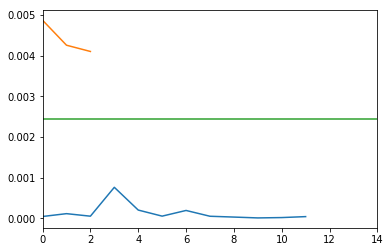

In [37]:
with tf.Session() as sess:
    saver.restore(sess, "C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_v3.ckpt")  # decode_without_input=True, iter=5000
    print("Model restored.") 
    print('Initialized')
    
    normal_score = []
    for count in range(len(tn_list)//batch_num):
        normal_sub = np.array(tn_list[count*batch_num:(count+1)*batch_num]) 
        (input_n, output_n) = sess.run([ae.input_, ae.output_], {p_input: normal_sub})
        err_n = abs(input_n-output_n).reshape(-1,step_num)
        for batch in range(batch_num):
           temp = np.dot( (err_n[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_n[batch] - mu ))
           normal_score.append(s[0])
           
    abnormal_score = []
    for count in range(len(ta_list)//batch_num):
        abnormal_sub = np.array(ta_list[count*batch_num:(count+1)*batch_num]) 
        (input_a, output_a) = sess.run([ae.input_, ae.output_], {p_input: abnormal_sub})
        err_a = abs(input_a-output_a).reshape(-1,step_num)
        for batch in range(batch_num):
           temp = np.dot( (err_a[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_a[batch] - mu ))
           abnormal_score.append(s[0])
             

    print('Predict result :')

    print("normal score ",normal_score)
    print("abnormal score ",abnormal_score)
    pd.Series(normal_score).plot()
    pd.Series(abnormal_score).plot()
    bar = threshold*np.ones(len(normal_score)+len(abnormal_score))
    pd.Series(bar).plot()

In [ ]:
# P = 1, R = 0.5